In [1]:
import pandas as pd 
import numpy as np 
import h5py
from cnn_model import CNNModel

import tflearn

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

luna_output = '/notebooks/ashish/luna16_patch/'
model_file = 'nodule3-classifier.tfl'

In [2]:
def load_images(filename):
    """
    Loads images contained in hdfs file
    """
    h5f2 = h5py.File(filename, 'r')
    X_test_images = h5f2['X']
    Y_test_labels = h5f2['Y']
    return X_test_images, Y_test_labels

hdfs_file = luna_output + 'test.h5'
X_test_images, Y_test_labels = load_images(hdfs_file)

print (X_test_images.shape, Y_test_labels.shape )

((1622, 50, 50, 1), (1622, 2))


In [3]:
def get_predictions(X_test_images, Y_test_labels):
    ## Model definition
    convnet  = CNNModel()
    network = convnet.define_network(X_test_images)
    model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='nodule3-classifier.tfl.ckpt')
    model.load(model_file)

    predictions = np.vstack(model.predict(X_test_images[:,:,:,:]))
    #label_predictions = np.vstack(model.predict_label(X_test_images[:,:,:,:]))
    score = model.evaluate(X_test_images, Y_test_labels)
    label_predictions = np.zeros_like(predictions)
    label_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return predictions, label_predictions

predictions, label_predictions = get_predictions(X_test_images, Y_test_labels)

In [4]:
print(predictions.shape, label_predictions.shape)

((1622, 2), (1622, 2))


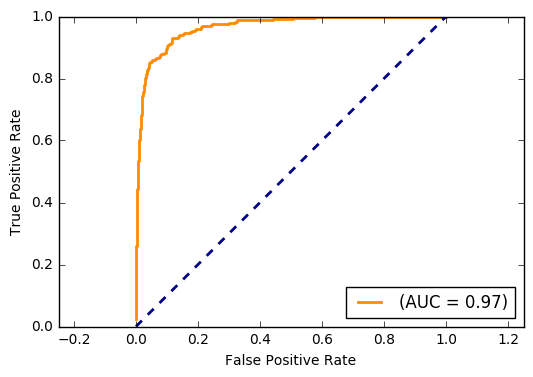

In [5]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.axis('equal')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    #plt.savefig('roc1.png', bbox_inches='tight')

def get_roc_curve(Y_test_labels, predictions):
    fpr, tpr, thresholds = roc_curve(Y_test_labels[:,1], predictions[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

fpr, tpr, roc_auc = get_roc_curve(Y_test_labels, predictions)
plot_roc_curve(fpr, tpr, roc_auc)

In [6]:
def get_metrics(Y_test_labels, label_predictions):
    cm = confusion_matrix(Y_test_labels[:,1], label_predictions[:,1])

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    precision = TP*1.0/(TP+FP)
    recall = TP*1.0/(TP+FN)
    specificity = TN*1.0/(TN+FP)

    return precision, recall, specificity, cm

precision, recall, specificity, cm = get_metrics(Y_test_labels, label_predictions)

print (precision, recall, specificity )

(0.85384615384615381, 0.78723404255319152, 0.9716417910447761)


Confusion matrix, without normalization
[[1302   38]
 [  60  222]]


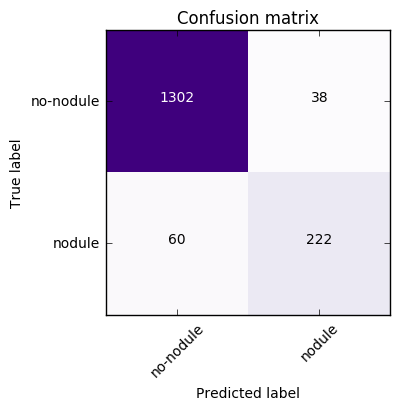

In [7]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['no-nodule', 'nodule'], title='Confusion matrix')
#plt.savefig('confusion_matrix.png', bbox_inches='tight')

(16, 50, 50)


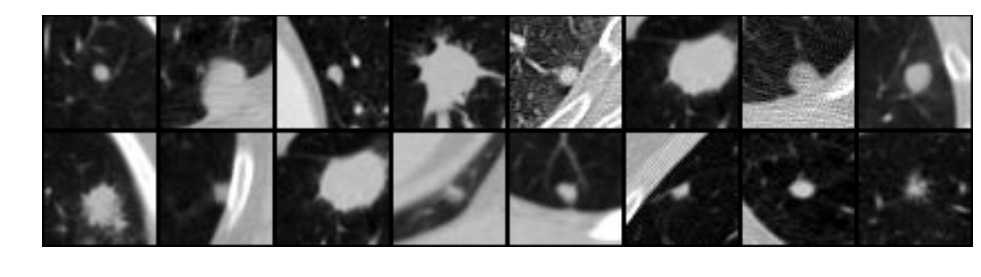

In [8]:
def format_image(image, num_images):
    idxs = np.random.choice(image.shape[0], num_images)
    M = image.shape[1]
    N = image.shape[2]
    imagex = np.squeeze(image[idxs, :, :, :])
    return imagex

def create_mosaic(image, nrows, ncols):
    """
    Tiles all the layers in nrows x ncols
    Args:
    ------
    image = 3d numpy array of M * N * number of filters dimensions
    nrows = integer representing number of images in a row
    ncol = integer representing number of images in a column
    returns formatted image
    """
    M = image.shape[1]
    N = image.shape[2]

    npad = ((0,0), (1,1), (1,1))
    image = np.pad(image, pad_width = npad, mode = 'constant',\
    constant_values = 0)
    M += 2
    N += 2
    image = image.reshape(nrows, ncols, M, N)
    image = np.transpose(image, (0,2,1,3))
    image = image.reshape(M*nrows, N*ncols)
    return image

def plot_predictions(images, filename):
    imagex = format_image(images, 16)
    mosaic = create_mosaic(imagex, 2, 8)
    plt.figure(figsize = (12, 12))
    plt.imshow(mosaic, cmap = 'gray')
    plt.axis('off')
    #plt.savefig(filename + '.png', bbox_inches='tight')

TP_images = X_test_images[(Y_test_labels[:,1] == 1) & (label_predictions[:,1] == 1), :,:,:]
FP_images = X_test_images[(Y_test_labels[:,1] == 0) & (label_predictions[:,1] == 1), :,:,:]
TN_images = X_test_images[(Y_test_labels[:,1] == 0) & (label_predictions[:,1] == 0), :,:,:]
FN_images = X_test_images[(Y_test_labels[:,1] == 1) & (label_predictions[:,1] == 0), :,:,:]

## Choose 16 images randomly
plot_predictions(TP_images, 'preds_tps')
#plot_predictions(TN_images, 'preds_tns')
#plot_predictions(FN_images, 'preds_fns')
#plot_predictions(FP_images, 'preds_fps')